# **Import packeges**

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import time
import os
import copy
from torchvision import datasets, models, transforms
from __future__ import print_function
import torchsummary
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

## ***Create data set and Load data:***


In [2]:
batch_size = 64
num_class = 10
num_epochs = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
train_data = torchvision.datasets.CIFAR10(root = "CIFAR10",
                             train = True,
                             transform = transforms.ToTensor(),
                             download = True)

test_data = torchvision.datasets.CIFAR10(root = "CIFAR10",
                             train = False,
                             transform = transforms.ToTensor(),
                             download = True)


train_size = int(len(train_data) * 0.8)
valid_size = int(len(train_data) * 0.2)
test_size = int(len(test_data))

train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])



train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=batch_size,
                                          shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [4]:
one_batch_images, one_batch_labels = next(iter(train_loader))
print(f"one batch imeges shape : {one_batch_images.shape}")
print(f"one batch labels shape : {one_batch_labels.shape}")
print(f"one batch labels type {set([x.item() for x in one_batch_labels])}")

one batch imeges shape : torch.Size([64, 3, 32, 32])
one batch labels shape : torch.Size([64])
one batch labels type {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## **Create Model**

In [7]:
class ResNet(torch.nn.Module):    
    def __init__(self, num_class):
        super(ResNet, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Linear(in_features=512, out_features=10, bias=False)

    def forward(self, x):
        x = self.base(x)
        return x

In [8]:
model = ResNet(num_class).to(device)
torchsummary.summary(model, (3, 32, 32))
#print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# **plot data**

1


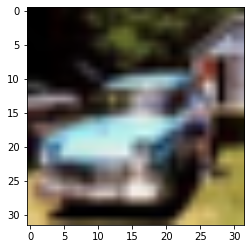

In [9]:
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, images.shape[0], 1)
image = images[idx, ...].squeeze(0)

image = np.moveaxis(image.cpu().numpy(), 0, -1)
plt.imshow(image, interpolation="bilinear")
print(labels[idx].item())

### **train and test**

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### ***train model:***

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
dataloaders_dict = {"train":train_loader, "test":test_loader, "val":valid_loader}
model_ft, hist = train_model(model, dataloaders_dict, loss, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 1.1010 Acc: 0.6170
val Loss: 0.8012 Acc: 0.7250

Epoch 1/24
----------
train Loss: 0.6761 Acc: 0.7657
val Loss: 0.6953 Acc: 0.7604

Epoch 2/24
----------
train Loss: 0.5143 Acc: 0.8212
val Loss: 0.6527 Acc: 0.7831

Epoch 3/24
----------
train Loss: 0.3883 Acc: 0.8648
val Loss: 0.6917 Acc: 0.7770

Epoch 4/24
----------
train Loss: 0.3011 Acc: 0.8946
val Loss: 0.6872 Acc: 0.7954

Epoch 5/24
----------
train Loss: 0.2284 Acc: 0.9205
val Loss: 0.7440 Acc: 0.7864

Epoch 6/24
----------
train Loss: 0.1853 Acc: 0.9343
val Loss: 0.7954 Acc: 0.7814

Epoch 7/24
----------
train Loss: 0.1493 Acc: 0.9483
val Loss: 0.8078 Acc: 0.7881

Epoch 8/24
----------
train Loss: 0.1146 Acc: 0.9590
val Loss: 0.8632 Acc: 0.7888

Epoch 9/24
----------
train Loss: 0.0989 Acc: 0.9657
val Loss: 0.8672 Acc: 0.7975

Epoch 10/24
----------
train Loss: 0.0777 Acc: 0.9735
val Loss: 0.9184 Acc: 0.7935

Epoch 11/24
----------
train Loss: 0.0733 Acc: 0.9746
val Loss: 0.9466 Acc: 0.7923

Ep